In [1]:
%matplotlib inline

import gym
import matplotlib
import numpy as np
import sys

from collections import defaultdict
if "../" not in sys.path:
  sys.path.append("../") 
from lib.envs.blackjack import BlackjackEnv
from lib import plotting

matplotlib.style.use('ggplot')

In [2]:
env = BlackjackEnv()

In [3]:
env.action_space.n

2

In [4]:
def make_epsilon_greedy_policy(Q, epsilon, nA):
    """
    Creates an epsilon-greedy policy based on a given Q-function and epsilon.
    
    Args:
        Q: A dictionary that maps from state -> action-values.
            Each value is a numpy array of length nA (see below)
        epsilon: The probability to select a random action . float between 0 and 1.
        nA: Number of actions in the environment.
    
    Returns:
        A function that takes the observation as an argument and returns
        the probabilities for each action in the form of a numpy array of length nA.
    
    """
    def policy_fn(observation):
        # Implement this!
        
        actions = np.ones(nA) * (epsilon / nA)
        action_values = Q[observation]
        
        best_action = np.argmax(action_values) 
        
        actions[best_action] += (1 - (epsilon / nA) * nA)
        
        return actions
        
    return policy_fn

In [46]:
def mc_control_epsilon_greedy(env, num_episodes, discount_factor=1.0, epsilon=0.1):
    """
    Monte Carlo Control using Epsilon-Greedy policies.
    Finds an optimal epsilon-greedy policy.
    
    Args:
        env: OpenAI gym environment.
        num_episodes: Number of episodes to sample.
        discount_factor: Gamma discount factor.
        epsilon: Chance the sample a random action. Float betwen 0 and 1.
    
    Returns:
        A tuple (Q, policy).
        Q is a dictionary mapping state -> action values.
        policy is a function that takes an observation as an argument and returns
        action probabilities
    """
    
    # Keeps track of sum and count of returns for each state
    # to calculate an average. We could use an array to save all
    # returns (like in the book) but that's memory inefficient.
    returns_sum = defaultdict(float)
    returns_count = defaultdict(float)
    
    # The final action-value function.
    # A nested dictionary that maps state -> (action -> action-value).
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    
    # The policy we're following
    policy = make_epsilon_greedy_policy(Q, epsilon, env.action_space.n)
    
    # Implement this!

    for i_episode in range(num_episodes):
        
        Episode = []
        
        observation = env.reset()
        #observation contains : score, dealer_score, usable_ace
        for t in range(100):
            
            action_probabilities = policy(observation)
            
            #print(action_probabilities)
            
            action = np.random.choice(len(action_probabilities), p= action_probabilities)
            
            #print(action)
            
            next_observation, reward, done, _ = env.step(action)
            
            #print(done)
            
            Episode.append([observation, action, reward])
            
            observation = next_observation
            
            if done:
                break
                
        #print(Episode)
            
        #Getting the Return

        G = 0

        #Backward view

        Episode_reverse = Episode
        Episode_reverse.reverse()

        for i, step in enumerate(Episode_reverse):

            print(step[:2])
            
            G = discount_factor * G + step[2]

            #First Visit Returns only condition
            if step[:2] not in [Episode_reverse[j][:2] for j in range(i+1,len(Episode_reverse))]:

                returns_sum[tuple(step[:2])] += G
                returns_count[tuple(step[:2])] += 1

                Q[step[0]][step[1]] = returns_sum[tuple(step[:2])] / returns_count[tuple(step[:2])]
                    
    return Q, policy

In [ ]:
Q, policy = mc_control_epsilon_greedy(env, num_episodes=500000, epsilon=0.1)

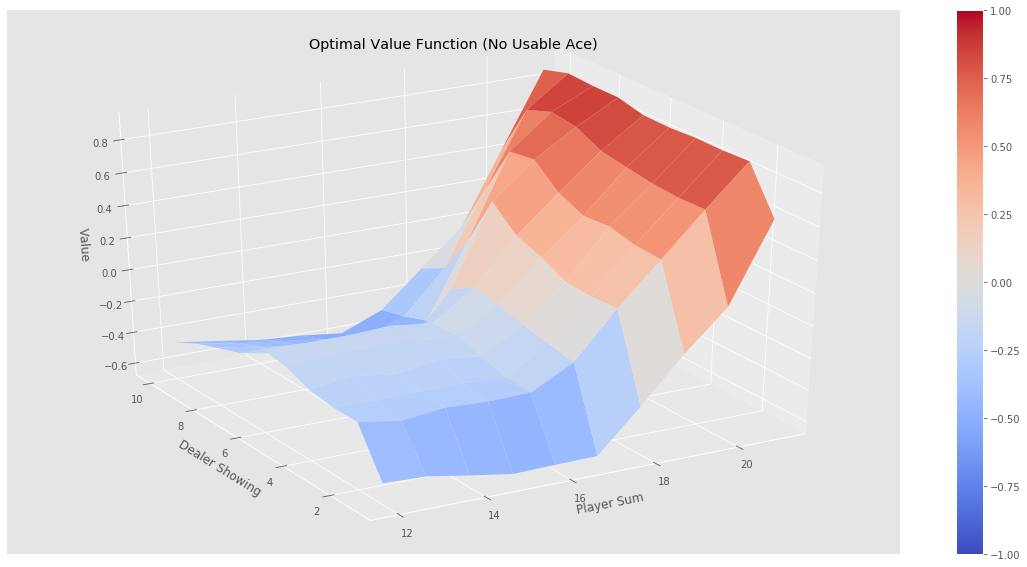

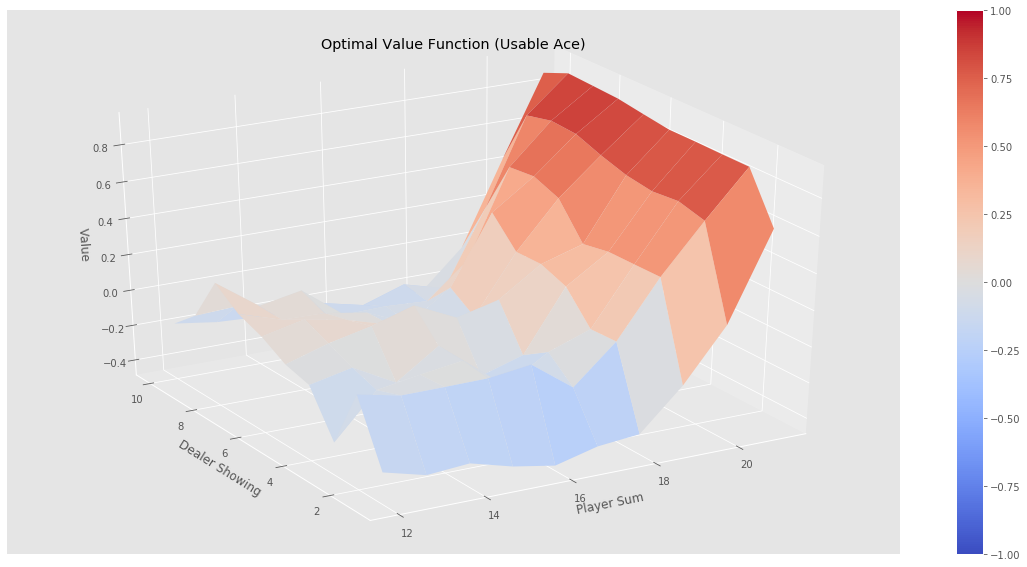

In [53]:
# For plotting: Create value function from action-value function
# by picking the best action at each state
V = defaultdict(float)
for state, actions in Q.items():
    action_value = np.max(actions)
    V[state] = action_value
plotting.plot_value_function(V, title="Optimal Value Function")